In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transform
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
import splitfolders

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

# Data Visualization & Preprocessing

In [3]:
data_dir = 'mri_brain'


print(os.listdir(data_dir))


['Brain Tumor', 'Healthy']


Let's work with fewer data points to get a hand on our ideas.

In [ ]:
import os
import shutil
import random

source_dir = 'mri_brain'  
target_dir = 'mri_brain_reduced' 
categories = ['Healthy', 'Brain Tumor']
n_images = 30

for cat in categories:
    os.makedirs(os.path.join(target_dir, cat), exist_ok=True)
    
    source_path = os.path.join(source_dir, cat)
    images = os.listdir(source_path)
    
    ## Random selection of images
    random.seed(42) ## For reproducibility
    selected_images = random.sample(images, n_images)
    
    # Copy of the images
    for img_name in selected_images:
        src = os.path.join(source_path, img_name)
        dst = os.path.join(target_dir, cat, img_name)
        shutil.copy(src, dst)

print(f"Folder {target_dir} created with {n_images} images per category.")

Dossier mri_brain_reduced créé avec 30 images par catégorie.


In [5]:
data_dir_reduced = 'mri_brain_reduced'
splitfolders.ratio(data_dir_reduced, output="mri_brain_sorted", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None, move=False)

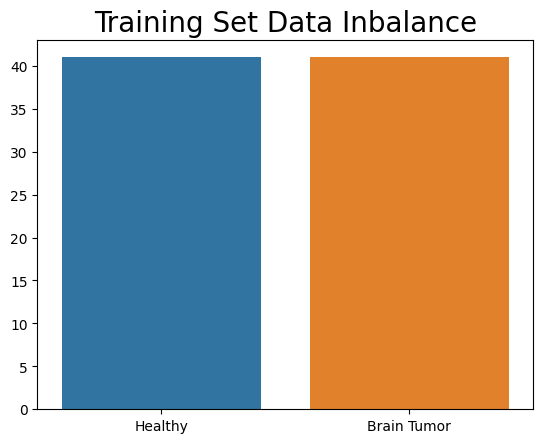

In [6]:
data_dir_sorted = 'mri_brain_sorted'
test_samplesize = pd.DataFrame.from_dict(
    {'Healthy': [len([os.path.join(data_dir_sorted+'/train/Healthy', filename) 
                     for filename in os.listdir(data_dir_sorted+'/train/Healthy')])], 
     'Brain Tumor': [len([os.path.join(data_dir_sorted+'/train/Brain Tumor', filename) 
                        for filename in os.listdir(data_dir_sorted+'/train/Brain Tumor')])]})


sns.barplot(data=test_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

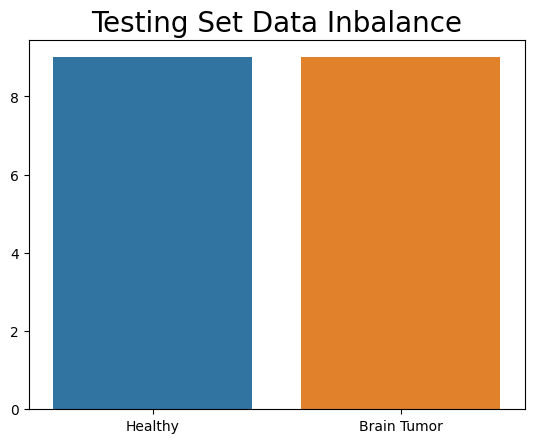

In [22]:
data_dir_sorted = 'mri_brain_sorted'
test_samplesize = pd.DataFrame.from_dict(
    {'Healthy': [len([os.path.join(data_dir_sorted+'/test/Healthy', filename) 
                     for filename in os.listdir(data_dir_sorted+'/test/Healthy')])], 
     'Brain Tumor': [len([os.path.join(data_dir_sorted+'/test/Brain Tumor', filename) 
                        for filename in os.listdir(data_dir_sorted+'/test/Brain Tumor')])]})


sns.barplot(data=test_samplesize).set_title('Testing Set Data Inbalance', fontsize=20)
plt.show()

In [7]:
train_dataset = ImageFolder(data_dir_sorted+'/train', 
                      transform=transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))


In [8]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 82
    Root location: mri_brain_sorted/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

In [9]:
test_dataset = ImageFolder(data_dir_sorted+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

test_dl = DataLoader(test_dataset, batch_size=256)


In [10]:
batch_size=4

train_dl=DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)

c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


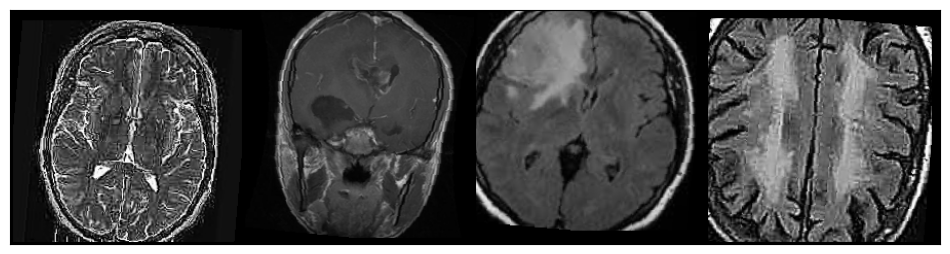

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Model

In [12]:
def train_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.sum(preds == labels).item() / len(preds)

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [13]:
class BrainTumorResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        out=self.network(xb)
        return out   

In [34]:
#define number of epochs
n=10

# #define dataset
# batch_size=4
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_dl = DataLoader(val_ds, batch_size*2, shuffle = True, num_workers=0, pin_memory=True)

#define model
model = BrainTumorResNet() ##.cuda() to use GPU

#define loss function
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}
for epoch in range(n):
    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")


    # #Validation step
    # model.eval()
    # val_infos=[]

    # for input, target in val_dl:
    #     pred=model(input)
    #     loss=criterion(pred,target)
    #     acc=train_accuracy(pred,target)
    #     val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
    #     val_infos.append(val_info)
    
    # batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    # val_loss = torch.stack(batch_losses).mean()           # combine losses
    # batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    # val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    # print(f"Valuation loss : {val_loss.item()}")
    # print(f"Valuation accuracy : {val_acc.item()}")

    # # save results to dictionary
    # to_add = {'train_loss': train_loss,
    #             'train_acc': train_acc,
    #             'val_loss': val_loss,
    #             'val_acc': val_acc}
    
    # # update performance dictionary
    # for key,val in to_add.items():
    #     if key in history:
    #         history[key].append(val)
    #     else:
    #         history[key] = [val]

c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch n°1


c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training accuracy : 0.7023809523809523
Training loss : 0.5967938899993896
Epoch n°2
Training accuracy : 0.7738095238095238
Training loss : 0.517550528049469
Epoch n°3
Training accuracy : 0.75
Training loss : 0.5353966355323792
Epoch n°4
Training accuracy : 0.8452380952380952
Training loss : 0.44978582859039307
Epoch n°5
Training accuracy : 0.9166666666666666
Training loss : 0.4135955572128296
Epoch n°6
Training accuracy : 0.9285714285714286
Training loss : 0.40284112095832825
Epoch n°7
Training accuracy : 0.9166666666666666
Training loss : 0.4143119156360626
Epoch n°8
Training accuracy : 0.8809523809523809
Training loss : 0.41929295659065247
Epoch n°9
Training accuracy : 0.8928571428571429
Training loss : 0.4277806580066681
Epoch n°10
Training accuracy : 0.9642857142857143
Training loss : 0.3600565493106842


In [ ]:
preds = []
targets = []

model.eval()
with torch.no_grad():
    for input, target in test_dl:
        # Transfert sur le GPU si vous en utilisez un (conseillé)
        # input = input.to(device) 
        
        pred = model(input)
        
        # On récupère l'indice de la classe maximale
        pred_binary = torch.argmax(pred, dim=1)
        
        # .extend() ajoute chaque élément individuellement à la liste
        preds.extend(pred_binary.cpu().numpy().tolist())
        targets.extend(target.cpu().numpy().tolist())

# Vérification : la taille doit être égale au nombre total d'images de test
print(f"Nombre de prédictions : {len(preds)}")

Nombre de prédictions : 18


In [ ]:
def test_accuracy(output, target):
    output = torch.tensor(np.array(output)).float()
    target = torch.tensor(np.array(target)).float()
    
    predicted = (output >= 0.5).float()
    
    correct = (predicted == target).sum().item()
    

    accuracy = correct / len(target)
    
    return accuracy

acc = test_accuracy(preds, targets)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9444


<Figure size 640x480 with 0 Axes>

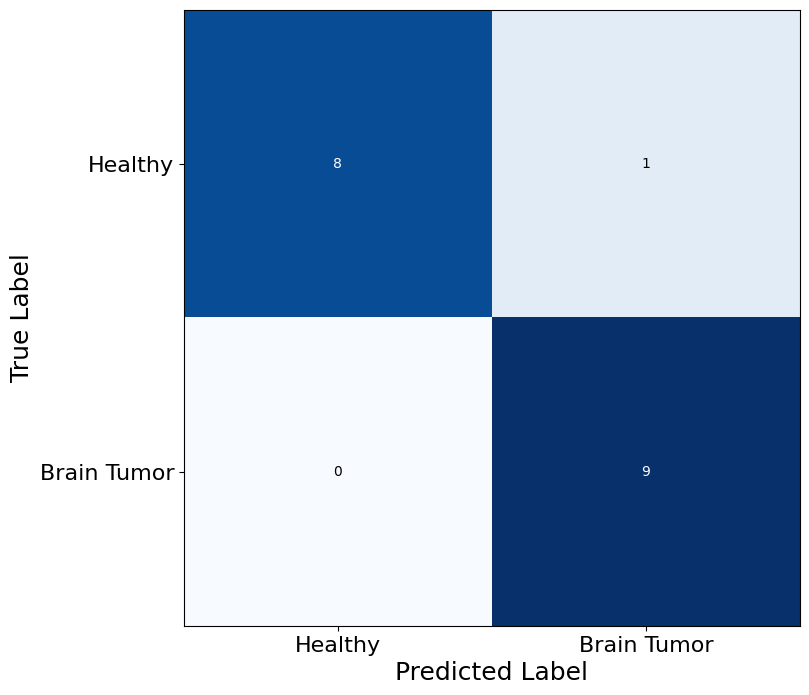

In [ ]:
plt.figure()

cm = confusion_matrix(targets, preds)

plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(targets)).sum() / len(preds)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.94
Recall of the model is 1.00
Precision of the model is 0.90
F1 Score of the model is 0.95


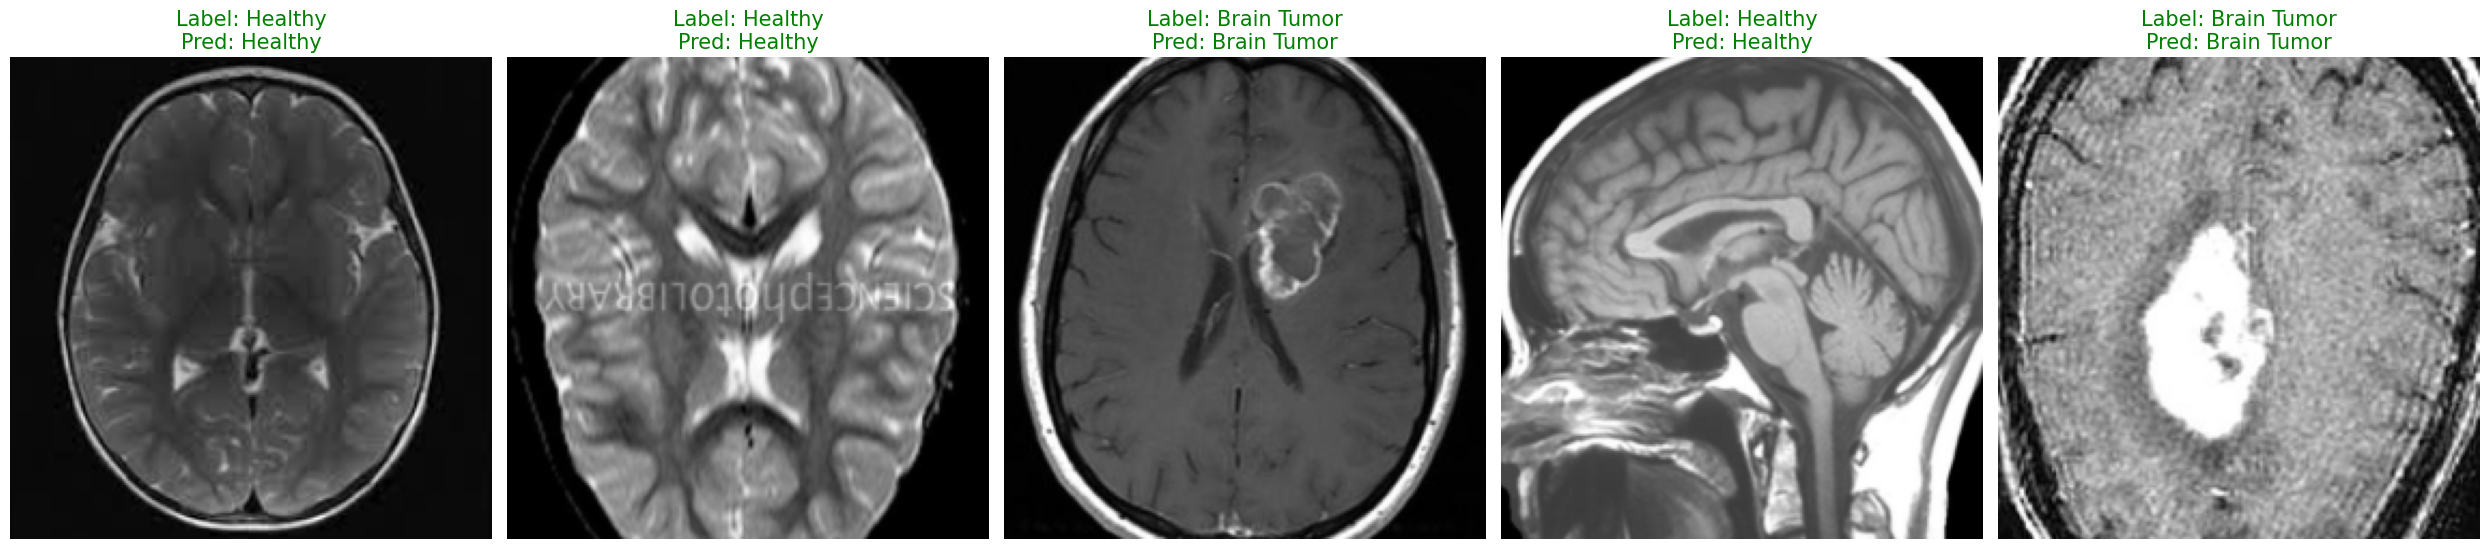

In [ ]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[preds[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

In [14]:
class BrainTumorConvNeXt(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.convnext_base(weights='IMAGENET1K_V1')
        # Geler l'entraînement de toutes les couches avant le classifieur
        for param in self.network.parameters():
            param.requires_grad = False

        # Obtenir la dernière couche du classifieur
        modules = list(self.network.modules())
        last_layer = None
        for module in reversed(modules):
            if isinstance(module, nn.Linear):
                last_layer = module
                break

        # Vérifier si une dernière couche linéaire a été trouvée
        if last_layer is not None:
            # Obtenir le nombre de fonctionnalités en entrée de la dernière couche
            num_features = last_layer.in_features

            # Remplacer la dernière couche par une nouvelle couche linéaire avec deux sorties
            self.network.classifier[2] = nn.Linear(num_features, 2)
    
    def forward(self, xb):
        out=self.network(xb)
        out = F.softmax(out, dim=1)
        return out   

In [ ]:
#define number of epochs
n=10


# #define dataset
# batch_size=4
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

#define model
model_conv = BrainTumorConvNeXt() 

#define loss function
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}
for epoch in range(n):
    
    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model_conv(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")
    
    # #Validation step
    # model.eval()
    # val_infos=[]

    # for input, target in val_dl:
    #     pred=model(input)
    #     loss=criterion(pred,target)
    #     acc=train_accuracy(pred,target)
    #     val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
    #     val_infos.append(val_info)
    
    # batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    # val_loss = torch.stack(batch_losses).mean()           # combine losses
    # batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    # val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    # print(f"Valuation loss : {val_loss.item()}")
    # print(f"Valuation accuracy : {val_acc.item()}")

    # # save results to dictionary
    # to_add = {'train_loss': train_loss,
    #             'train_acc': train_acc,
    #             'val_loss': val_loss,
    #             'val_acc': val_acc}
    
    # # update performance dictionary
    # for key,val in to_add.items():
    #     if key in history:
    #         history[key].append(val)
    #     else:
    #         history[key] = [val]

Epoch n°1


c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training accuracy : 0.6071428571428571
Training loss : 0.683030903339386
Epoch n°2
Training accuracy : 0.7619047619047619
Training loss : 0.6404179930686951
Epoch n°3
Training accuracy : 0.8452380952380952
Training loss : 0.6153079271316528
Epoch n°4
Training accuracy : 0.8571428571428571
Training loss : 0.588462769985199
Epoch n°5
Training accuracy : 0.8452380952380952
Training loss : 0.567951500415802
Epoch n°6
Training accuracy : 0.9285714285714286
Training loss : 0.5670595765113831
Epoch n°7
Training accuracy : 0.8452380952380952
Training loss : 0.5645518898963928
Epoch n°8
Training accuracy : 0.8809523809523809
Training loss : 0.5509864091873169
Epoch n°9
Training accuracy : 0.8333333333333334
Training loss : 0.5571255087852478
Epoch n°10
Training accuracy : 0.9047619047619048
Training loss : 0.5318065881729126


In [ ]:
preds_conv = []
targets_conv = []

model_conv.eval()
with torch.no_grad():

    for input, target in test_dl:
        
        pred = model_conv(input)
        
        pred_binary = torch.argmax(pred, dim=1)
        
        preds_conv.extend(pred_binary.cpu().numpy().tolist())
        targets_conv.extend(target.cpu().numpy().tolist())

# Verify that the size matches the total number of test images
print(f"Number of predictions : {len(preds_conv)}")

Nombre de prédictions : 18


<Figure size 640x480 with 0 Axes>

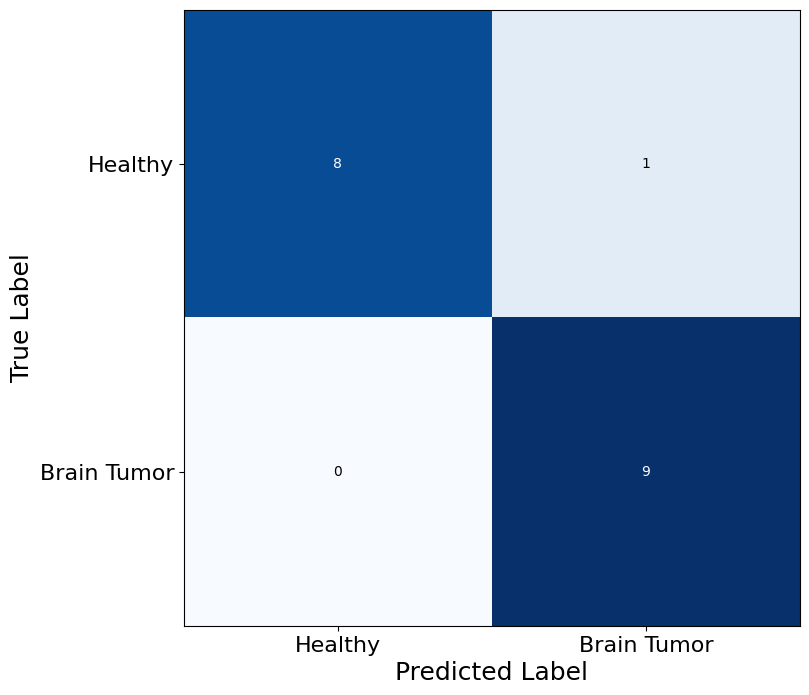

In [ ]:
plt.figure()

cm_conv = confusion_matrix(targets_conv, preds_conv)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds_conv) == np.array(targets_conv)).sum() / len(preds_conv)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.94
Recall of the model is 1.00
Precision of the model is 0.90
F1 Score of the model is 0.95


In [ ]:
acc_conv = test_accuracy(preds_conv, targets_conv)
print(f"Accuracy: {acc_conv:.4f}")

Accuracy: 0.9444


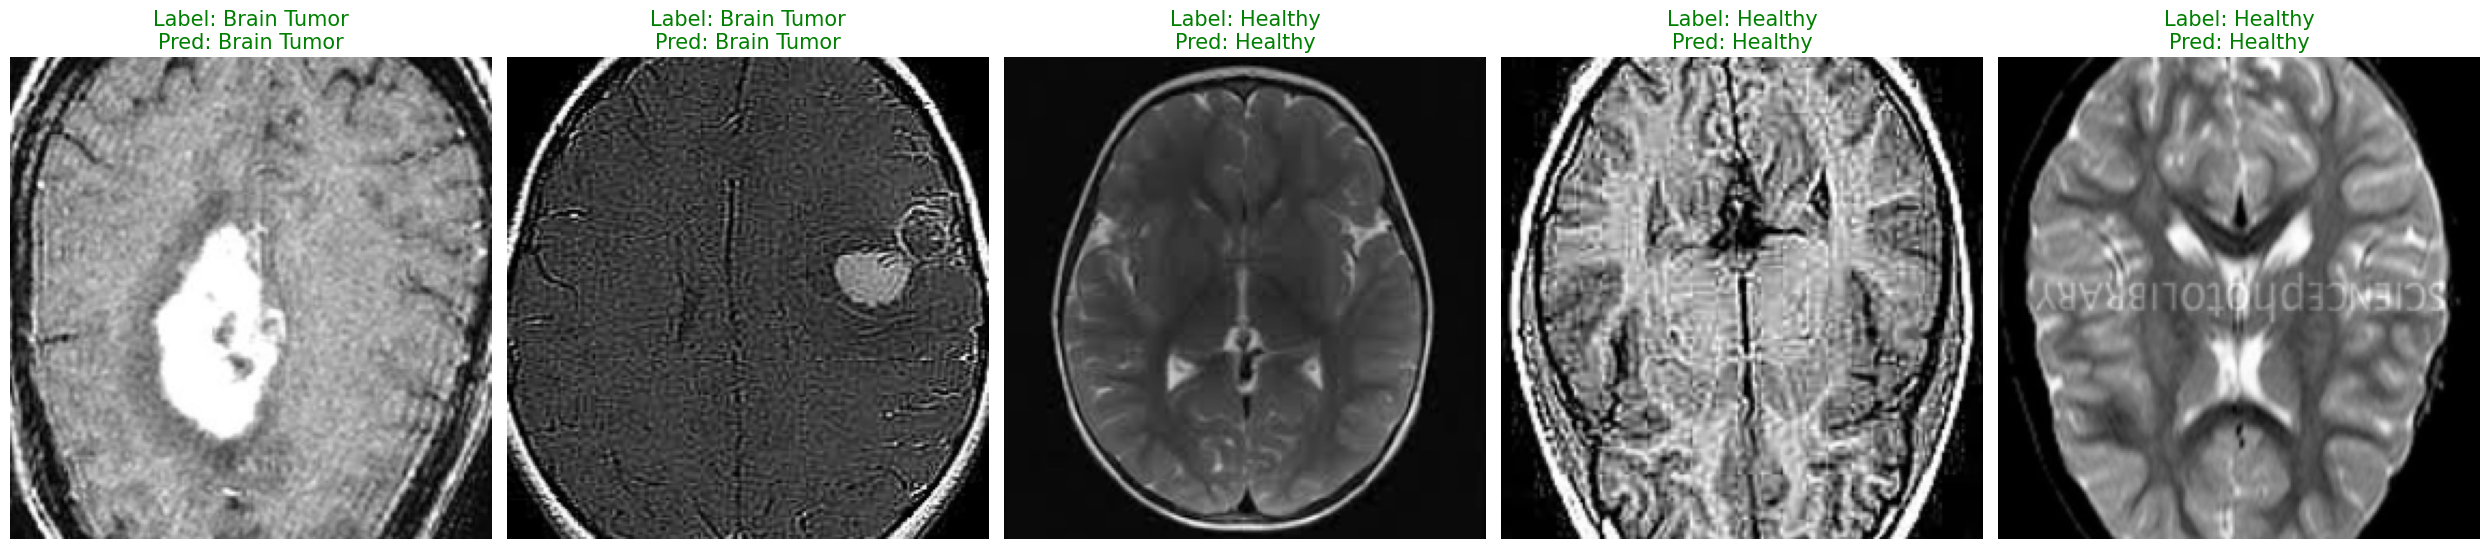

In [ ]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[preds_conv[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

## Comparaison entre Bruit Gaussien et Bruit Ricien

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddRicianNoise(object):
    """
    Ajoute un bruit de Rice standard.
    Formule : sqrt((I + n_re)^2 + n_im^2)
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n_re = torch.randn(noise_shape) * self.sigma
        n_im = torch.randn(noise_shape) * self.sigma
        
        # Application de la formule standard de la magnitude
        # Le bruit se diffuse sur les 3 canaux (R,G,B) de manière identique
        noisy = torch.sqrt((tensor + n_re)**2 + n_im**2)
        
        return noisy

In [16]:
# Taille standard pour ResNet et ConvNeXt
img_size = 224

# Transformations de base (sans bruit)
base_transform = transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
])

# Normalisation (à appliquer APRES le bruit)
# On utilise les statistiques ImageNet
normalize = transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
sigma = 0.01

# SCÉNARIO 1 : Baseline (Standard)
train_transform_baseline = transform.Compose([
    base_transform,
    normalize
])

# SCÉNARIO 2 : Bruit Gaussien
train_transform_gaussian = transform.Compose([
    base_transform,
    AddGaussianNoise(std=sigma), # Sigma de 0.05 est un bon point de départ
    normalize
])

# SCÉNARIO 3 : Bruit de Rice
train_transform_rician = transform.Compose([
    base_transform,
    AddRicianNoise(sigma=sigma), # Même intensité pour comparer équitablement
    normalize
])

# Transformation de TEST (Toujours sans bruit !)
test_transform = transform.Compose([
    transform.Resize((img_size, img_size)),
    transform.ToTensor(),
    normalize
])

In [ ]:
data_dir_sorted = 'mri_brain_sorted' 

# --- DATASETS ---

# Entraînement : Les 3 scénarios avec leurs bruits respectifs
train_ds_base = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_baseline)
train_ds_gauss = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_gaussian)
train_ds_rice = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_rician)

# Validation : Sans bruit pour comparer les modèles sur une base neutre
val_ds = ImageFolder(os.path.join(data_dir_sorted, 'val'), transform=test_transform)

# Test : Sans bruit pour l'évaluation finale
test_ds = ImageFolder(os.path.join(data_dir_sorted, 'test'), transform=test_transform)

# --- LOADERS ---

batch_size = 4 # Adapté pour vos tests locaux

train_loader_base = DataLoader(train_ds_base, batch_size=batch_size, shuffle=True)
train_loader_gauss = DataLoader(train_ds_gauss, batch_size=batch_size, shuffle=True)
train_loader_rice = DataLoader(train_ds_rice, batch_size=batch_size, shuffle=True)

# Pour la validation et le test, shuffle=False pour garder l'ordre des prédictions
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Datasets chargés : {len(train_ds_base)} train, {len(val_ds)} val, {len(test_ds)} test")

Datasets chargés : 82 train, 10 val, 18 test


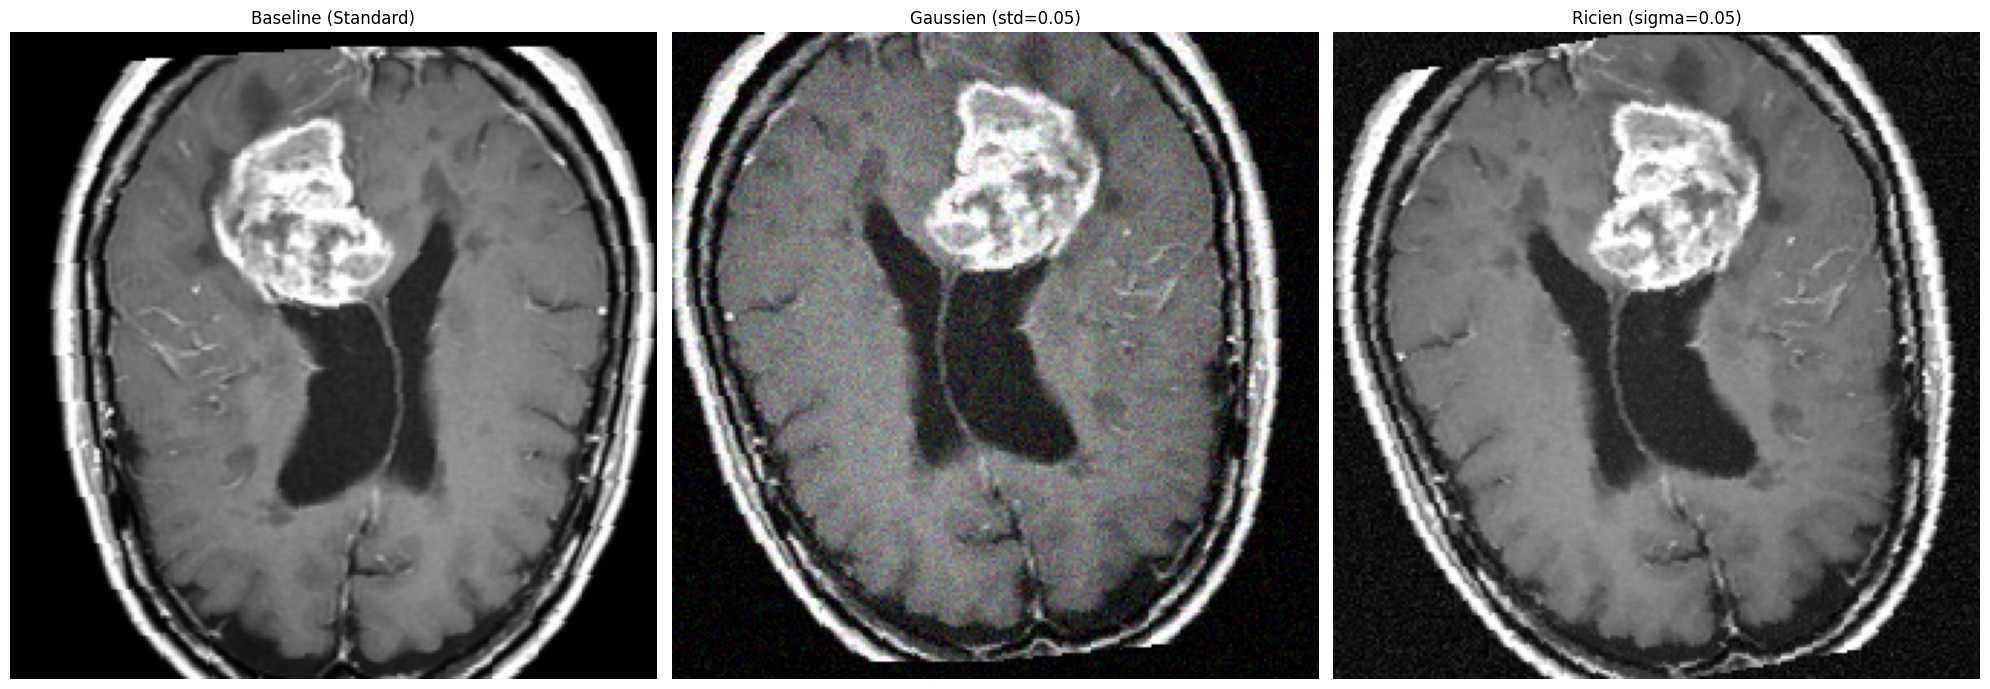

Valeur min (Base) : -2.1179 (Normalisée)
Valeur min (Gauss) : -2.9930 (Normalisée)
Valeur min (Rice) : -2.1126 (Normalisée)


In [ ]:
def imshow_dataset(tensor, title=None):
    # 1. On déplace les dimensions de (C, H, W) vers (H, W, C)
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    
    # 2. On annule la normalisation ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    # 3. On force les valeurs entre 0 et 1 pour éviter les artefacts d'affichage
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# On choisit un index d'image
idx = 4

# On récupère l'image de chaque dataset (déjà transformée)
img_base, label = train_ds_base[idx]
img_gauss, _ = train_ds_gauss[idx]
img_rice, _ = train_ds_rice[idx]

plt.figure(figsize=(20, 7))

# Affichage Baseline
plt.subplot(1, 3, 1)
imshow_dataset(img_base, "Baseline (Standard)")

# Affichage Gaussien
plt.subplot(1, 3, 2)
imshow_dataset(img_gauss, f"Gaussien (std={sigma})")

# Affichage Ricien
plt.subplot(1, 3, 3)
imshow_dataset(img_rice, f"Ricien (sigma={sigma})")

plt.tight_layout()
plt.show()

# Vérification numérique du fond pour confirmer le biais
print(f"Valeur min (Base) : {img_base.min():.4f} (Normalisée)")
print(f"Valeur min (Gauss) : {img_gauss.min():.4f} (Normalisée)")
print(f"Valeur min (Rice) : {img_rice.min():.4f} (Normalisée)")

In [135]:
import torch

# 1. On récupère un échantillon de l'image de base (après ToTensor, avant Normalize)
# On prend un coin de l'image (0:5, 0:5) qui est censé être le fond noir
sample_base, _ = train_ds_base[0]
pixels_base = sample_base[0, 0:5, 0:5] # Canal Rouge, bloc 5x5

# 2. On applique le bruit de Rice (avec votre classe actuelle)
rician_transformer = AddRicianNoise(sigma=0.01)
sample_rice = rician_transformer(sample_base)
pixels_rice = sample_rice[0, 0:5, 0:5] # Même bloc 5x5

print("--- VALEURS DES PIXELS (ZONE NOIRE) ---")
print("\nImage Originale (Base):")
print(pixels_base)

print("\nImage avec Bruit de Rice (Sigma=0.01):")
print(pixels_rice)

# Vérification statistique
print(f"\nMinimum Base: {pixels_base.min().item():.6f}")
print(f"Minimum Rice: {pixels_rice.min().item():.6f}")

--- VALEURS DES PIXELS (ZONE NOIRE) ---

Image Originale (Base):
tensor([[-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179]])

Image avec Bruit de Rice (Sigma=0.01):
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

Minimum Base: -2.117904
Minimum Rice: 1.000000


In [88]:
def compute_accuracy(outputs, labels):
    # On prend l'indice de la probabilité maximale (0 ou 1)
    _, preds = torch.max(outputs, dim=1)
    # On compare avec les vrais labels et on calcule la moyenne
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_scenario(model, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        train_accs = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            # Utilisation de la nouvelle fonction compatible PyTorch
            train_accs.append(compute_accuracy(outputs, labels))
        
        scheduler.step()
        
        # Phase de Validation
        model.eval()
        val_losses = []
        val_accs = []
        # On garde ces listes pour votre analyse finale par scénario
        final_val_preds = []
        final_val_targets = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                val_accs.append(compute_accuracy(outputs, labels))
                
                # Récupération pour vos outils de diagnostic (Matrice de confusion, etc.)
                _, preds = torch.max(outputs, dim=1)
                final_val_preds.extend(preds.cpu().numpy().tolist())
                final_val_targets.extend(labels.cpu().numpy().tolist())

        # Moyennes de l'époque
        h_train_loss = np.mean(train_losses)
        h_train_acc = np.mean(train_accs)
        h_val_loss = np.mean(val_losses)
        h_val_acc = np.mean(val_accs)

        history['train_loss'].append(h_train_loss)
        history['train_acc'].append(h_train_acc)
        history['val_loss'].append(h_val_loss)
        history['val_acc'].append(h_val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {h_train_loss:.4f} - Acc: {h_train_acc:.4f} | Val Acc: {h_val_acc:.4f}")

    return history, final_val_preds, final_val_targets

In [101]:
n_epochs = 10

# 1. Entraînement Baseline
print("\n--- Training ResNet50: BASELINE ---")
model_res_base = BrainTumorResNet()
history_res_base,final_val_preds_base,final_val_targets_base = train_scenario(model_res_base, train_loader_base, val_loader,n_epochs=n_epochs)

# 2. Entraînement Gaussien
print("\n--- Training ResNet50: GAUSSIAN NOISE ---")
model_res_gauss = BrainTumorResNet()
history_res_gauss,final_val_preds_gauss,final_val_targets_gauss = train_scenario(model_res_gauss, train_loader_gauss, val_loader,n_epochs=n_epochs)

# 3. Entraînement Ricien (Votre hypothèse)
print("\n--- Training ResNet50: RICIAN NOISE ---")
model_res_rician = BrainTumorResNet()
history_res_rician,final_val_preds_rice,final_val_targets_rice = train_scenario(model_res_rician, train_loader_rice, val_loader,n_epochs=n_epochs)


--- Training ResNet50: BASELINE ---
Epoch 1/10 - Loss: 0.6369 - Acc: 0.6548 | Val Acc: 0.5000
Epoch 2/10 - Loss: 0.5491 - Acc: 0.7500 | Val Acc: 0.4167
Epoch 3/10 - Loss: 0.5322 - Acc: 0.7619 | Val Acc: 0.7500
Epoch 4/10 - Loss: 0.5215 - Acc: 0.7857 | Val Acc: 0.5833
Epoch 5/10 - Loss: 0.5847 - Acc: 0.7143 | Val Acc: 0.6667
Epoch 6/10 - Loss: 0.5075 - Acc: 0.8095 | Val Acc: 0.5833
Epoch 7/10 - Loss: 0.4734 - Acc: 0.8571 | Val Acc: 0.9167
Epoch 8/10 - Loss: 0.5471 - Acc: 0.7500 | Val Acc: 0.6667
Epoch 9/10 - Loss: 0.5657 - Acc: 0.7262 | Val Acc: 0.5000
Epoch 10/10 - Loss: 0.4781 - Acc: 0.8333 | Val Acc: 0.6667

--- Training ResNet50: GAUSSIAN NOISE ---
Epoch 1/10 - Loss: 0.7223 - Acc: 0.5119 | Val Acc: 0.4167
Epoch 2/10 - Loss: 0.6701 - Acc: 0.6190 | Val Acc: 0.5833
Epoch 3/10 - Loss: 0.5603 - Acc: 0.7738 | Val Acc: 0.6667
Epoch 4/10 - Loss: 0.7057 - Acc: 0.5833 | Val Acc: 0.4167
Epoch 5/10 - Loss: 0.5446 - Acc: 0.7381 | Val Acc: 0.4167
Epoch 6/10 - Loss: 0.5577 - Acc: 0.7381 | Val Acc

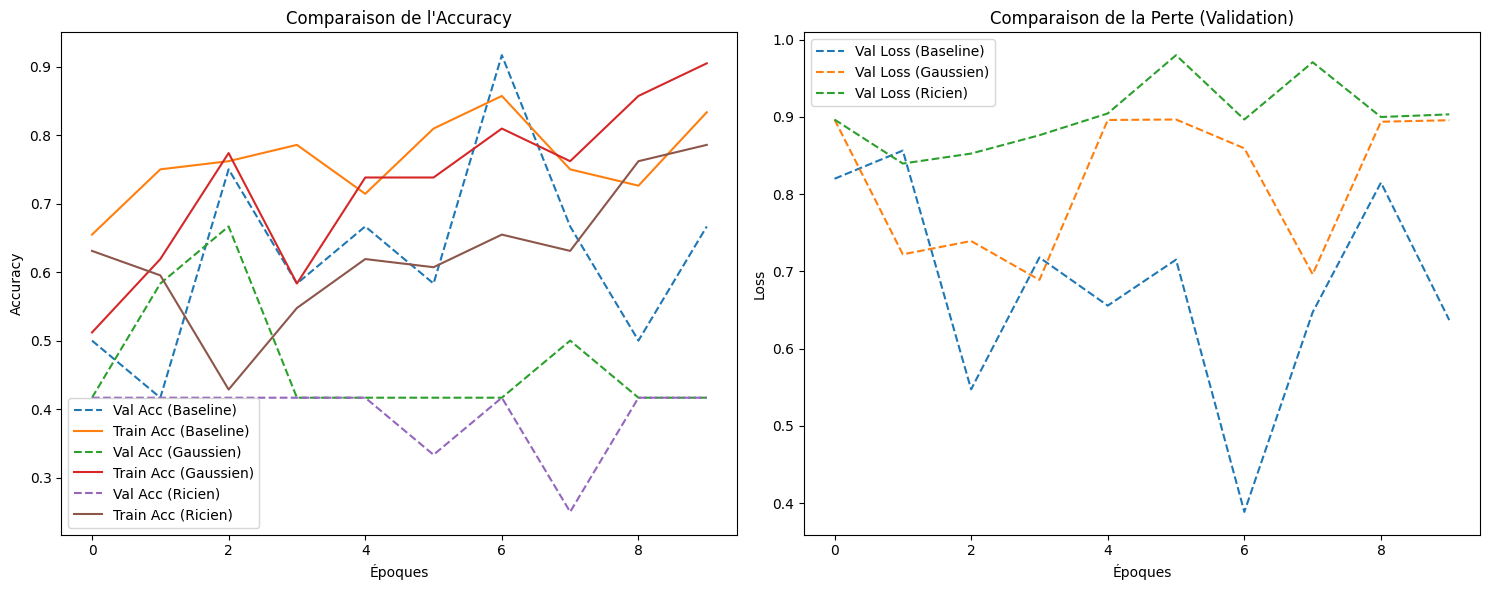

In [103]:
def plot_comparison(histories, names):
    plt.figure(figsize=(15, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_acc'], label=f'Val Acc ({name})', linestyle='--')
        plt.plot(hist['train_acc'], label=f'Train Acc ({name})')
    plt.title('Comparaison de l\'Accuracy')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_loss'], label=f'Val Loss ({name})', linestyle='--')
    plt.title('Comparaison de la Perte (Validation)')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Appel de la fonction
plot_comparison(
    [history_res_base, history_res_gauss, history_res_rician], 
    ['Baseline', 'Gaussien', 'Ricien']
)

C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\T

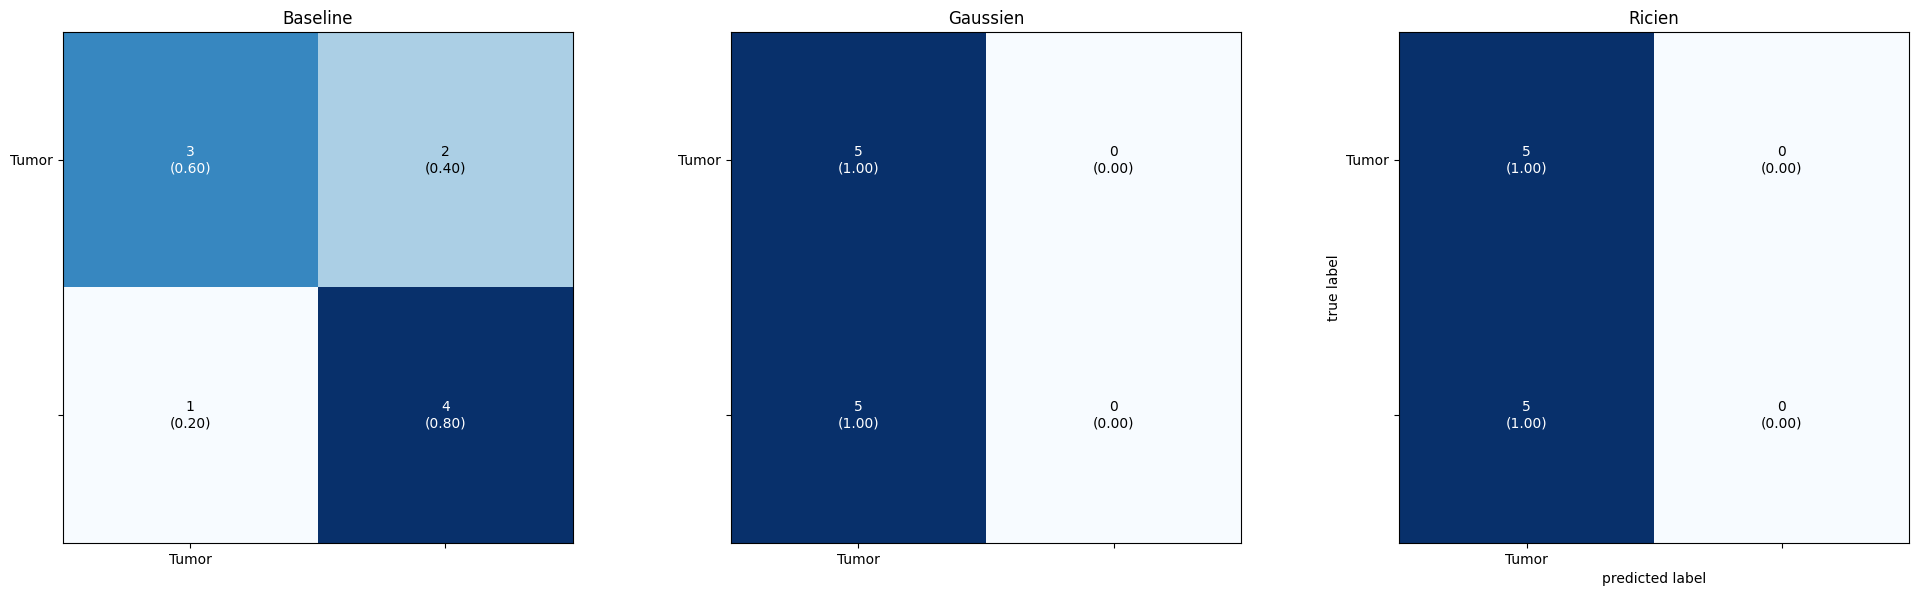

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
all_preds = [final_val_preds_base, final_val_preds_gauss, final_val_preds_rice]
titles = ['Baseline', 'Gaussien', 'Ricien']

for i, (p, t) in enumerate(zip(all_preds, [final_val_targets_base, final_val_targets_gauss, final_val_targets_rice])):
    cm = confusion_matrix(t, p)
    plot_confusion_matrix(conf_mat=cm, axis=axes[i], show_normed=True)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(['Healthy', 'Tumor'])
    axes[i].set_yticklabels(['Healthy', 'Tumor'])

plt.tight_layout()
plt.show()

In [106]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def get_metrics(targets, preds, name):
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average='binary')
    return {'Scénario': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

metrics_list = [
    get_metrics(final_val_targets_base, final_val_preds_base, 'Baseline'),
    get_metrics(final_val_targets_gauss, final_val_preds_gauss, 'Gaussien'),
    get_metrics(final_val_targets_rice, final_val_preds_rice, 'Ricien')
]

df_results = pd.DataFrame(metrics_list)
print(df_results)

   Scénario  Accuracy  Precision  Recall  F1-Score
0  Baseline       0.7   0.666667     0.8  0.727273
1  Gaussien       0.5   0.000000     0.0  0.000000
2    Ricien       0.5   0.000000     0.0  0.000000


c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
